# Multiclass Classification

In [1]:
import os
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import matplotlib.pyplot as plt

In [2]:
data_folder = "data"
stack_name = os.path.join(data_folder, "data_stack.h5")
df_stack = pd.read_hdf(stack_name)

In [3]:
def q_labeling(train_target, test_target):
    qs = [train_target.quantile(i/5) for i in range(1, 5)]
    
    def labeling(x):
        if x < qs[0]:
            label = 1
        elif x < qs[1]:
            label = 2
        elif x < qs[2]:
            label = 3
        elif x < qs[3]:
            label = 4
        else:
            label = 5
        return label
    
    q_train = train_target.apply(labeling)
    q_test = test_target.apply(labeling)
    
    return q_train, q_test

In [4]:
def q_restoring(q_label, target):
    qs = [target.quantile(i/5) for i in range(1, 6)]
    
    medians = [] # quantile is highly skewed
    for i in range(5):
        if i == 0:
            medians.append(target[(target<qs[i])].median())
        elif i < 4:
            medians.append(target[(target>=qs[i])&(target>qs[i])].median())
        else:
            medians.append(target[(target>=qs[i])].median())

    def restoring(x):
        return medians[int(x)-1]
    return q_label.apply(restoring)

    return medians

In [5]:
is_ratio = 0.6
isos_split = df_stack.index[int(len(df_stack)*is_ratio)][0]
df_stack_is = df_stack[df_stack.index.get_level_values(0)<isos_split]
df_stack_os = df_stack[df_stack.index.get_level_values(0)>=isos_split]

In [6]:
is_name = os.path.join(data_folder, "df_is.h5")
df_stack_is.to_hdf(is_name, key='df', mode='w', format="table")
os_name = os.path.join(data_folder, "df_os.h5")
df_stack_os.to_hdf(os_name, key='df', mode='w', format="table")

df_stack_is_c = df_stack_is.copy()
df_stack_os_c = df_stack_os.copy()

In [7]:
features = list(df_stack_is.columns)[:-1]
target = list(df_stack_is.columns)[-1]

categorical_columns = ['fgsc']
X = df_stack_is_c[features]
y = df_stack_is_c[target]

X_test = df_stack_os_c[features]
y_test = df_stack_os_c[target]

In [8]:
y_deciles = [y.min()] + [y.quantile(i/10) for i in range(1, 11)] + [y.max()]
y_test_deciles = [y_test.min()] + [y_test.quantile(i/10) for i in range(1, 11)] + [y_test.max()]

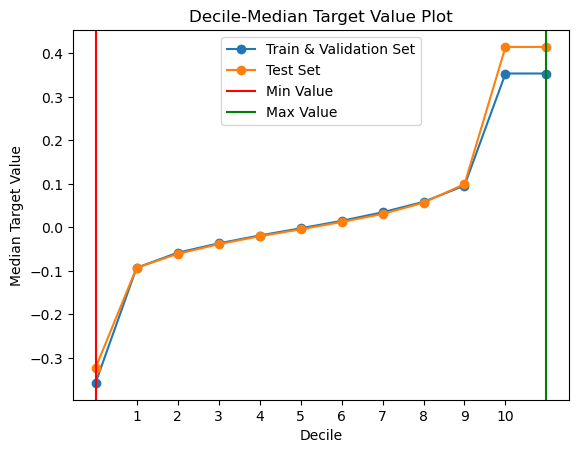

In [9]:
model_folder = "model"
decile_median_name = os.path.join(model_folder, "Decile_Median.png")
fig1, ax1 = plt.subplots()
ax1.plot(y_deciles, "-o", label="Train & Validation Set")
ax1.plot(y_test_deciles, "-o", label="Test Set")
ax1.axvline(x=0, c='r', label='Min Value')
ax1.axvline(x=11, c='g', label='Max Value')
ax1.legend(loc='upper center')
ax1.set_title("Decile-Median Target Value Plot")
ax1.set_xlabel("Decile")
ax1.set_ylabel("Median Target Value")
ax1.set_xticks(np.arange(1, 11))
fig1.figure.savefig(decile_median_name, bbox_inches='tight', dpi=300)

## Model fitting without sample weight decay

In [172]:
models_dict = dict()

In [10]:
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [11]:
kf_results = []

model = CatBoostClassifier(cat_features=categorical_columns, verbose=0)

param_grid = {
    'depth': [4],
    'learning_rate': [0.2]
}

cv = StratifiedKFold(n_splits=5)

y_total, _ = q_labeling(y, y)
for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y_total)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]
    
    if fold == 0:
        X_train = X[X.index.get_level_values(0)>valid_end]
        X_valid = X[X.index.get_level_values(0)<=valid_end]
        y_train = y[y.index.get_level_values(0)>valid_end]
        y_valid = y[y.index.get_level_values(0)<=valid_end]
    elif fold == 4:
        X_train = X[X.index.get_level_values(0)<valid_start]
        X_valid = X[X.index.get_level_values(0)>=valid_start]
        y_train = y[y.index.get_level_values(0)<valid_start]
        y_valid = y[y.index.get_level_values(0)>=valid_start]
    else:
        X_train = X[(X.index.get_level_values(0)<valid_start)|(X.index.get_level_values(0)>valid_end)]
        X_valid = X[(X.index.get_level_values(0)>=valid_start)&(X.index.get_level_values(0)<=valid_end)]
        y_train = y[(y.index.get_level_values(0)<valid_start)|(y.index.get_level_values(0)>valid_end)]
        y_valid = y[(y.index.get_level_values(0)>=valid_start)&(y.index.get_level_values(0)<=valid_end)]
        
    # embargo 1 month
    if fold > 0:
        dt = X_valid.index.get_level_values(0)[0]
        X_valid = X_valid[X_valid.index.get_level_values(0)>dt]
        y_valid = y_valid[y_valid.index.get_level_values(0)>dt]
    else:
        pass
    
    # quintile labeling
    y_train, y_valid = q_labeling(y_train, y_valid)

    grid_search = GridSearchCV(model, param_grid,
                               cv=StratifiedKFold(n_splits=3),
                               scoring='accuracy', verbose=0)
    grid_search.fit(X_train, y_train)

    print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
    print(f"Best Params - {grid_search.best_params_}")
    
    best_params = grid_search.best_params_
    best_model = CatBoostClassifier(cat_features=categorical_columns,
                                    verbose=0, **best_params)
    best_model.fit(X_train, y_train)
    
    y_pred_kf = best_model.predict(X_valid)
    accuracy_kf = accuracy_score(y_valid, y_pred_kf)
    kf_results.append(accuracy_kf)
    print(f'K-Fold Split {fold + 1} Accuracy: {accuracy_kf:.4f}')

kf_mean_accuracy = np.mean(kf_results)
print(f'K-Fold Mean Accuracy: {kf_mean_accuracy:.4f}')

End of Fold 1: Score - 0.2075
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 1 Accuracy: 0.2081
End of Fold 2: Score - 0.1947
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 2 Accuracy: 0.2218
End of Fold 3: Score - 0.2029
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 3 Accuracy: 0.2282
End of Fold 4: Score - 0.2154
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 4 Accuracy: 0.2172
End of Fold 5: Score - 0.2103
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 5 Accuracy: 0.2039
K-Fold Mean Accuracy: 0.2158


In [12]:
tscv_results = []
# TSCV
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(tscv.split(X, y_total)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]

    X_train = X[X.index.get_level_values(0)<valid_start]
    X_valid = X[X.index.get_level_values(0)>=valid_start]
    y_train = y[y.index.get_level_values(0)<valid_start]
    y_valid = y[y.index.get_level_values(0)>=valid_start]
    
    # quintile labeling
    y_train, y_valid = q_labeling(y_train, y_valid)
    
    # sample weights
    sample_weights = np.ones(len(y_train))
    
    model = best_model
    grid_search = GridSearchCV(model, param_grid,
                           cv=TimeSeriesSplit(n_splits=3),
                           scoring='accuracy', verbose=0)
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
    print(f"Best Params - {grid_search.best_params_}")
    
    best_params = grid_search.best_params_
    best_model = CatBoostClassifier(cat_features=categorical_columns,
                                    verbose=0, **best_params)
    best_model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred_tscv = best_model.predict(X_valid)
    accuracy_tscv = accuracy_score(y_valid, y_pred_tscv)
    tscv_results.append(accuracy_tscv)
    print(f'TSCV Split {fold + 1} Accuracy: {accuracy_tscv:.4f}')

tscv_mean_accuracy = np.mean(tscv_results)
print(f'TSCV Mean Accuracy: {tscv_mean_accuracy:.4f}')

TSCV Split 1 Accuracy: 0.3846
TSCV Split 2 Accuracy: 0.3715
TSCV Split 3 Accuracy: 0.3498
TSCV Split 4 Accuracy: 0.3027
TSCV Split 5 Accuracy: 0.1989
TSCV Mean Accuracy: 0.3215


In [174]:
models_dict['no_decay'] = [best_model, kf_results, tscv_results]

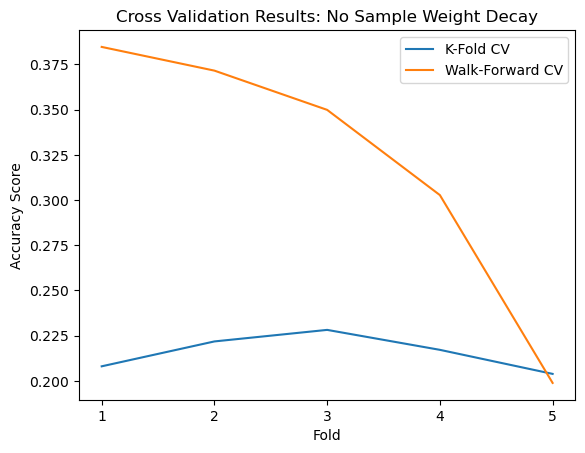

In [124]:
no_decay_name = os.path.join(model_folder, "CV_no_decay.png")
decay_dict = {'K-Fold CV':models_dict['no_decay'][1],
              'Walk-Forward CV':models_dict['no_decay'][2]}
xs = [1, 2, 3, 4, 5]
fig4, ax4 = plt.subplots()
pd.DataFrame(decay_dict, index=xs).plot(ax=ax4)
ax4.set_title("Cross Validation Results: No Sample Weight Decay")
ax4.set_xticks(xs)
ax4.set_xlabel("Fold")
ax4.set_ylabel("Accuracy Score")
fig4.figure.savefig(no_decay_name, bbox_inches='tight', dpi=300)

## Model fitting with Linear sample weight decay

In [10]:
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [135]:
kf_results = []

model = CatBoostClassifier(cat_features=categorical_columns, verbose=0)

param_grid = {
    'depth': [4],
    'learning_rate': [0.2]
}

cv = StratifiedKFold(n_splits=5)

y_total, _ = q_labeling(y, y)
for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y_total)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]
    
    if fold == 0:
        X_train = X[X.index.get_level_values(0)>valid_end]
        X_valid = X[X.index.get_level_values(0)<=valid_end]
        y_train = y[y.index.get_level_values(0)>valid_end]
        y_valid = y[y.index.get_level_values(0)<=valid_end]
    elif fold == 4:
        X_train = X[X.index.get_level_values(0)<valid_start]
        X_valid = X[X.index.get_level_values(0)>=valid_start]
        y_train = y[y.index.get_level_values(0)<valid_start]
        y_valid = y[y.index.get_level_values(0)>=valid_start]
    else:
        X_train = X[(X.index.get_level_values(0)<valid_start)|(X.index.get_level_values(0)>valid_end)]
        X_valid = X[(X.index.get_level_values(0)>=valid_start)&(X.index.get_level_values(0)<=valid_end)]
        y_train = y[(y.index.get_level_values(0)<valid_start)|(y.index.get_level_values(0)>valid_end)]
        y_valid = y[(y.index.get_level_values(0)>=valid_start)&(y.index.get_level_values(0)<=valid_end)]
        
    # embargo 1 month
    if fold > 0:
        dt = X_valid.index.get_level_values(0)[0]
        X_valid = X_valid[X_valid.index.get_level_values(0)>dt]
        y_valid = y_valid[y_valid.index.get_level_values(0)>dt]
    else:
        pass
    
    # quintile labeling
    y_train, y_valid = q_labeling(y_train, y_valid)
    
    # linear sample weight decay
    sample_weights = y_train.index.get_level_values(0).to_series().rank(pct=True)
    sample_weights = (sample_weights / sample_weights.sum()).to_numpy()

    grid_search = GridSearchCV(model, param_grid,
                               cv=StratifiedKFold(n_splits=3),
                               scoring='accuracy', verbose=0)
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
    print(f"Best Params - {grid_search.best_params_}")
    
    best_params = grid_search.best_params_
    best_model = CatBoostClassifier(cat_features=categorical_columns,
                                    verbose=0, **best_params)
    best_model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred_kf = best_model.predict(X_valid)
    accuracy_kf = accuracy_score(y_valid, y_pred_kf)
    kf_results.append(accuracy_kf)
    print(f'K-Fold Split {fold + 1} Accuracy: {accuracy_kf:.4f}')

kf_mean_accuracy = np.mean(kf_results)
print(f'K-Fold Mean Accuracy: {kf_mean_accuracy:.4f}')

End of Fold 1: Score - 0.2070
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 1 Accuracy: 0.2132
End of Fold 2: Score - 0.1929
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 2 Accuracy: 0.2173
End of Fold 3: Score - 0.2039
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 3 Accuracy: 0.2194
End of Fold 4: Score - 0.2160
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 4 Accuracy: 0.2249
End of Fold 5: Score - 0.2066
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 5 Accuracy: 0.2180
K-Fold Mean Accuracy: 0.2186


In [136]:
tscv_results = []
# TSCV
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(tscv.split(X, y_total)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]

    X_train = X[X.index.get_level_values(0)<valid_start]
    X_valid = X[X.index.get_level_values(0)>=valid_start]
    y_train = y[y.index.get_level_values(0)<valid_start]
    y_valid = y[y.index.get_level_values(0)>=valid_start]
    
    # quintile labeling
    y_train, y_valid = q_labeling(y_train, y_valid)
    
    # linear sample weight decay
    sample_weights = y_train.index.get_level_values(0).to_series().rank(pct=True)
    sample_weights = (sample_weights / sample_weights.sum()).to_numpy()
    
    model = best_model
    grid_search = GridSearchCV(model, param_grid,
                           cv=TimeSeriesSplit(n_splits=3),
                           scoring='accuracy', verbose=0)
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
    print(f"Best Params - {grid_search.best_params_}")
    
    best_params = grid_search.best_params_
    best_model = CatBoostClassifier(cat_features=categorical_columns,
                                    verbose=0, **best_params)
    best_model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred_tscv = best_model.predict(X_valid)
    accuracy_tscv = accuracy_score(y_valid, y_pred_tscv)
    tscv_results.append(accuracy_tscv)
    print(f'TSCV Split {fold + 1} Accuracy: {accuracy_tscv:.4f}')

tscv_mean_accuracy = np.mean(tscv_results)
print(f'TSCV Mean Accuracy: {tscv_mean_accuracy:.4f}')

TSCV Split 1 Accuracy: 0.4028
TSCV Split 2 Accuracy: 0.4177
TSCV Split 3 Accuracy: 0.4081
TSCV Split 4 Accuracy: 0.3498
TSCV Split 5 Accuracy: 0.2124
TSCV Mean Accuracy: 0.3581


In [175]:
models_dict['linear'] = [best_model, kf_results, tscv_results]

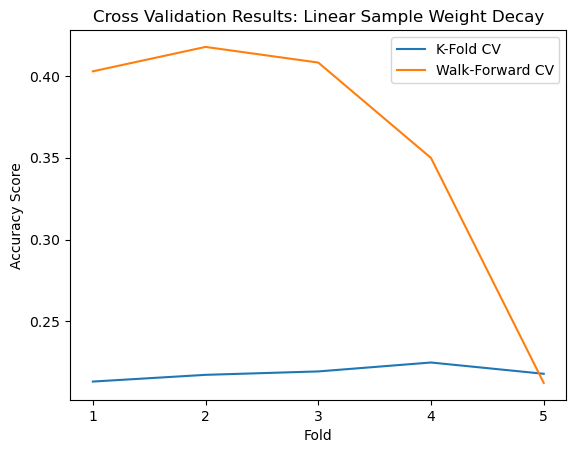

In [137]:
decay_name = os.path.join(model_folder, "CV_decay.png")
decay_dict = {'K-Fold CV':models_dict['linear'][1],
              'Walk-Forward CV':models_dict['linear'][2]}
xs = [1, 2, 3, 4, 5]
fig5, ax5 = plt.subplots()
pd.DataFrame(decay_dict, index=xs).plot(ax=ax5)
ax5.set_title("Cross Validation Results: Linear Sample Weight Decay")
ax5.set_xticks(xs)
ax5.set_xlabel("Fold")
ax5.set_ylabel("Accuracy Score")
fig5.figure.savefig(decay_name, bbox_inches='tight', dpi=300)

## Model fitting with exponential sample weight decay

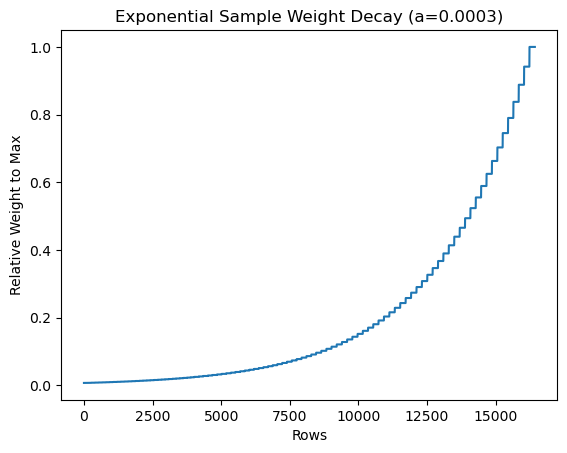

In [181]:
exp_weight_name = os.path.join(model_folder, "exp_weight.png")

a = 0.0003
sample_weights = y.index.get_level_values(0).to_series().rank(ascending=False, method='min')
sample_weights = np.array([(1-a) ** i for i in list(sample_weights)])

fig6, ax6 = plt.subplots()
pd.Series(sample_weights).plot(ax=ax6)
ax6.set_title(f"Exponential Sample Weight Decay (a={a})")
ax6.set_xlabel("Rows")
ax6.set_ylabel("Relative Weight to Max")
fig6.figure.savefig(exp_weight_name, bbox_inches='tight', dpi=300)

In [160]:
kf_results = []

model = CatBoostClassifier(cat_features=categorical_columns, verbose=0)

param_grid = {
    'depth': [4],
    'learning_rate': [0.2]
}

cv = StratifiedKFold(n_splits=5)

y_total, _ = q_labeling(y, y)
for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y_total)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]
    
    if fold == 0:
        X_train = X[X.index.get_level_values(0)>valid_end]
        X_valid = X[X.index.get_level_values(0)<=valid_end]
        y_train = y[y.index.get_level_values(0)>valid_end]
        y_valid = y[y.index.get_level_values(0)<=valid_end]
    elif fold == 4:
        X_train = X[X.index.get_level_values(0)<valid_start]
        X_valid = X[X.index.get_level_values(0)>=valid_start]
        y_train = y[y.index.get_level_values(0)<valid_start]
        y_valid = y[y.index.get_level_values(0)>=valid_start]
    else:
        X_train = X[(X.index.get_level_values(0)<valid_start)|(X.index.get_level_values(0)>valid_end)]
        X_valid = X[(X.index.get_level_values(0)>=valid_start)&(X.index.get_level_values(0)<=valid_end)]
        y_train = y[(y.index.get_level_values(0)<valid_start)|(y.index.get_level_values(0)>valid_end)]
        y_valid = y[(y.index.get_level_values(0)>=valid_start)&(y.index.get_level_values(0)<=valid_end)]
        
    # embargo 1 month
    if fold > 0:
        dt = X_valid.index.get_level_values(0)[0]
        X_valid = X_valid[X_valid.index.get_level_values(0)>dt]
        y_valid = y_valid[y_valid.index.get_level_values(0)>dt]
    else:
        pass
    
    # quintile labeling
    y_train, y_valid = q_labeling(y_train, y_valid)
    
    # linear sample weight decay
    a = 0.001
    sample_weights = y_train.index.get_level_values(0).to_series().rank(ascending=False, method='min')
    sample_weights = np.array([(1-a) ** i for i in list(sample_weights)])

    grid_search = GridSearchCV(model, param_grid,
                               cv=StratifiedKFold(n_splits=3),
                               scoring='accuracy', verbose=0)
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
    print(f"Best Params - {grid_search.best_params_}")
    
    best_params = grid_search.best_params_
    best_model = CatBoostClassifier(cat_features=categorical_columns,
                                    verbose=0, **best_params)
    best_model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred_kf = best_model.predict(X_valid)
    accuracy_kf = accuracy_score(y_valid, y_pred_kf)
    kf_results.append(accuracy_kf)
    print(f'K-Fold Split {fold + 1} Accuracy: {accuracy_kf:.4f}')

kf_mean_accuracy = np.mean(kf_results)
print(f'K-Fold Mean Accuracy: {kf_mean_accuracy:.4f}')

End of Fold 1: Score - 0.2097
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 1 Accuracy: 0.2049
End of Fold 2: Score - 0.2000
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 2 Accuracy: 0.2213
End of Fold 3: Score - 0.2108
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 3 Accuracy: 0.2024
End of Fold 4: Score - 0.2122
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 4 Accuracy: 0.2095
End of Fold 5: Score - 0.2107
Best Params - {'depth': 4, 'learning_rate': 0.2}
K-Fold Split 5 Accuracy: 0.2066
K-Fold Mean Accuracy: 0.2089


In [161]:
tscv_results = []
# TSCV
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(tscv.split(X, y_total)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]

    X_train = X[X.index.get_level_values(0)<valid_start]
    X_valid = X[X.index.get_level_values(0)>=valid_start]
    y_train = y[y.index.get_level_values(0)<valid_start]
    y_valid = y[y.index.get_level_values(0)>=valid_start]
    
    # quintile labeling
    y_train, y_valid = q_labeling(y_train, y_valid)
    
    # linear sample weight decay
    a = 0.001
    sample_weights = y_train.index.get_level_values(0).to_series().rank(ascending=False, method='min')
    sample_weights = np.array([(1-a) ** i for i in list(sample_weights)])
    
    model = best_model
    grid_search = GridSearchCV(model, param_grid,
                           cv=TimeSeriesSplit(n_splits=3),
                           scoring='accuracy', verbose=0)
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
    print(f"Best Params - {grid_search.best_params_}")
    
    best_params = grid_search.best_params_
    best_model = CatBoostClassifier(cat_features=categorical_columns,
                                    verbose=0, **best_params)
    best_model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred_tscv = best_model.predict(X_valid)
    accuracy_tscv = accuracy_score(y_valid, y_pred_tscv)
    tscv_results.append(accuracy_tscv)
    print(f'TSCV Split {fold + 1} Accuracy: {accuracy_tscv:.4f}')

tscv_mean_accuracy = np.mean(tscv_results)
print(f'TSCV Mean Accuracy: {tscv_mean_accuracy:.4f}')

End of Fold 1: Score - 0.2267
Best Params - {'depth': 4, 'learning_rate': 0.2}
TSCV Split 1 Accuracy: 0.2133
End of Fold 2: Score - 0.2142
Best Params - {'depth': 4, 'learning_rate': 0.2}
TSCV Split 2 Accuracy: 0.2047
End of Fold 3: Score - 0.2077
Best Params - {'depth': 4, 'learning_rate': 0.2}
TSCV Split 3 Accuracy: 0.2100
End of Fold 4: Score - 0.2091
Best Params - {'depth': 4, 'learning_rate': 0.2}
TSCV Split 4 Accuracy: 0.2149
End of Fold 5: Score - 0.2066
Best Params - {'depth': 4, 'learning_rate': 0.2}
TSCV Split 5 Accuracy: 0.1901
TSCV Mean Accuracy: 0.2066


In [176]:
models_dict['exponential'] = [best_model, kf_results, tscv_results]

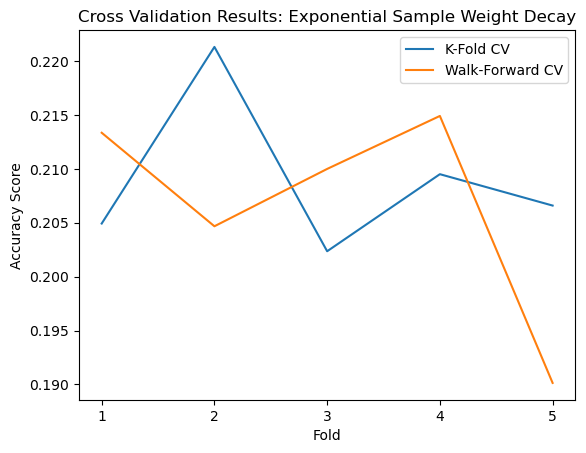

In [177]:
decay_name = os.path.join(model_folder, "CV_exp_decay.png")
decay_dict = {'K-Fold CV':models_dict['exponential'][1],
              'Walk-Forward CV':models_dict['exponential'][2]}
xs = [1, 2, 3, 4, 5]
fig6, ax6 = plt.subplots()
pd.DataFrame(decay_dict, index=xs).plot(ax=ax6)
ax6.set_title("Cross Validation Results: Exponential Sample Weight Decay")
ax6.set_xticks(xs)
ax6.set_xlabel("Fold")
ax6.set_ylabel("Accuracy Score")
fig6.figure.savefig(decay_name, bbox_inches='tight', dpi=300)

## Model Evaluation

### No decay

In [202]:
model_type = "no_decay"
best_model = models_dict[model_type][0]

In [165]:
predictions = best_model.predict(X_test)
y_hat = predictions.reshape((len(predictions)))
y_true = (q_labeling(y, y_test)[1]).to_numpy()

In [166]:
test_score = accuracy_score(y_hat, y_true)
print(f"Test Accuracy: {test_score:.4f}")

Test Accuracy: 0.2105


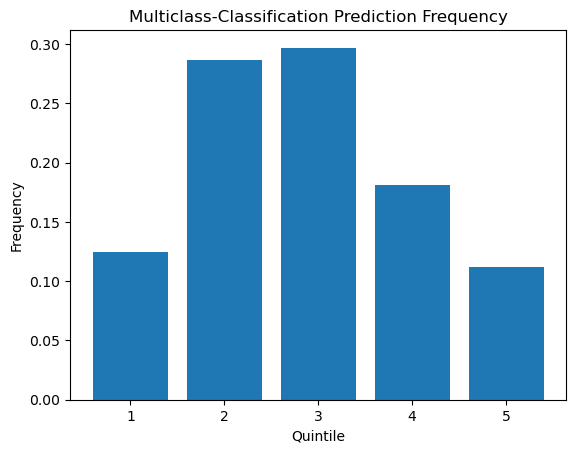

In [182]:
df_hat = pd.DataFrame({'predict':y_hat, 'true':y_true})
prediction_frequency_name = os.path.join(model_folder, f"{model_type}_Prediction_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots()
predict_count = df_hat['predict'].value_counts().sort_index()
predict_count = predict_count / predict_count.sum()
ax3.bar(x_bar, predict_count)
ax3.set_title("Multiclass-Classification Prediction Frequency")
ax3.set_xlabel("Quintile")
ax3.set_ylabel("Frequency")
fig3.figure.savefig(prediction_frequency_name, bbox_inches='tight', dpi=300)

In [169]:
true_dict = dict()
for i in range(1, 6):
    true_count = df_hat[df_hat['predict']==i]['true'].value_counts().sort_index()
    true_count = true_count / true_count.sum()
    true_dict[i] = true_count

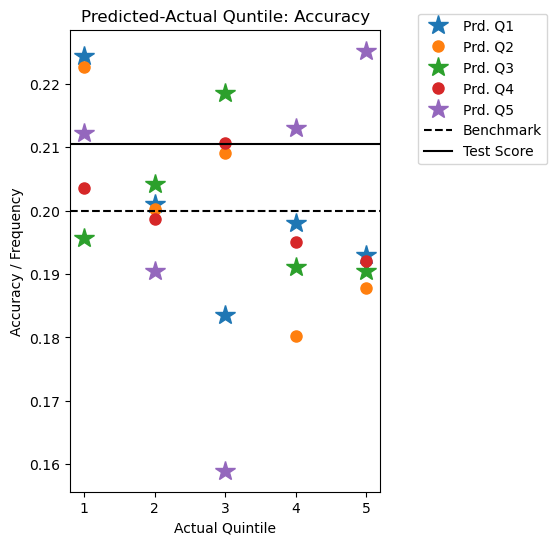

In [171]:
actual_frequency_name = os.path.join(model_folder, f"{model_type}_Actual_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots(figsize=(4,6))
ax3.plot(x_bar, true_dict[1], "*", markersize=15, label="Prd. Q1")
ax3.plot(x_bar, true_dict[2], "o", markersize=8, label="Prd. Q2")
ax3.plot(x_bar, true_dict[3], "*", markersize=15, label="Prd. Q3")
ax3.plot(x_bar, true_dict[4], "o", markersize=8, label="Prd. Q4")
ax3.plot(x_bar, true_dict[5], "*", markersize=15, label="Prd. Q5")
ax3.axhline(y=0.20, c="black", ls="--", label="Benchmark")
ax3.axhline(y=test_score, c="black", label="Test Score")
ax3.set_title("Predicted-Actual Quntile: Accuracy")
ax3.set_xticks([1, 2, 3, 4, 5])
ax3.set_xlabel("Actual Quintile")
ax3.set_ylabel("Accuracy / Frequency")
ax3.legend(bbox_to_anchor=(1.1, 1.05))
fig3.figure.savefig(actual_frequency_name, bbox_inches='tight', dpi=300)

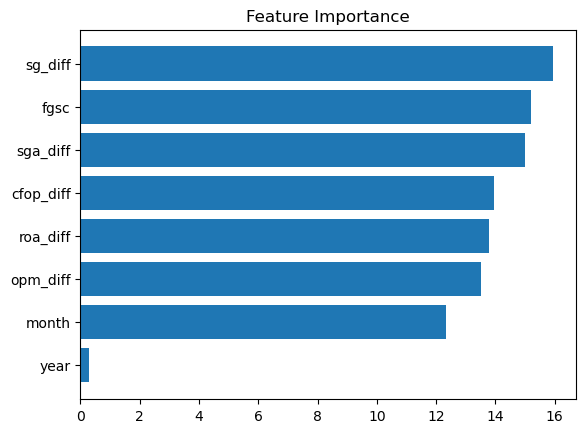

In [203]:
importance_name = os.path.join(model_folder, f"{model_type}_Importance.png")
df_importance = best_model.get_feature_importance(prettified=True)
df_importance = df_importance.sort_values(by='Importances').iloc[-10:]
fig7, ax7 = plt.subplots()
ax7.barh(df_importance['Feature Id'], df_importance['Importances'])
ax7.set_title("Feature Importance")
fig7.figure.savefig(importance_name, bbox_inches='tight', dpi=300)

### Linear Decay

In [202]:
model_type = "linear"
best_model = models_dict[model_type][0]

In [165]:
predictions = best_model.predict(X_test)
y_hat = predictions.reshape((len(predictions)))
y_true = (q_labeling(y, y_test)[1]).to_numpy()

In [166]:
test_score = accuracy_score(y_hat, y_true)
print(f"Test Accuracy: {test_score:.4f}")

Test Accuracy: 0.2105


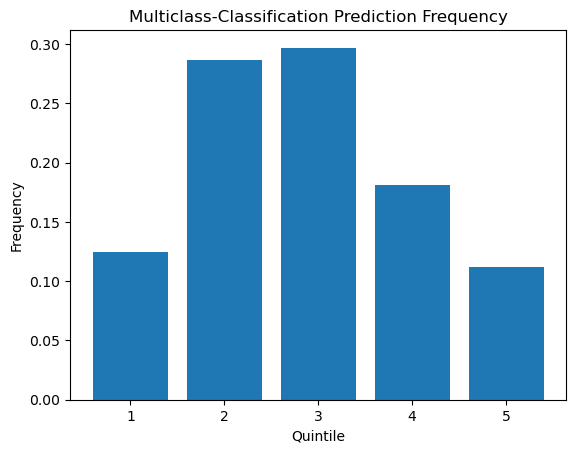

In [182]:
df_hat = pd.DataFrame({'predict':y_hat, 'true':y_true})
prediction_frequency_name = os.path.join(model_folder, f"{model_type}_Prediction_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots()
predict_count = df_hat['predict'].value_counts().sort_index()
predict_count = predict_count / predict_count.sum()
ax3.bar(x_bar, predict_count)
ax3.set_title("Multiclass-Classification Prediction Frequency")
ax3.set_xlabel("Quintile")
ax3.set_ylabel("Frequency")
fig3.figure.savefig(prediction_frequency_name, bbox_inches='tight', dpi=300)

In [169]:
true_dict = dict()
for i in range(1, 6):
    true_count = df_hat[df_hat['predict']==i]['true'].value_counts().sort_index()
    true_count = true_count / true_count.sum()
    true_dict[i] = true_count

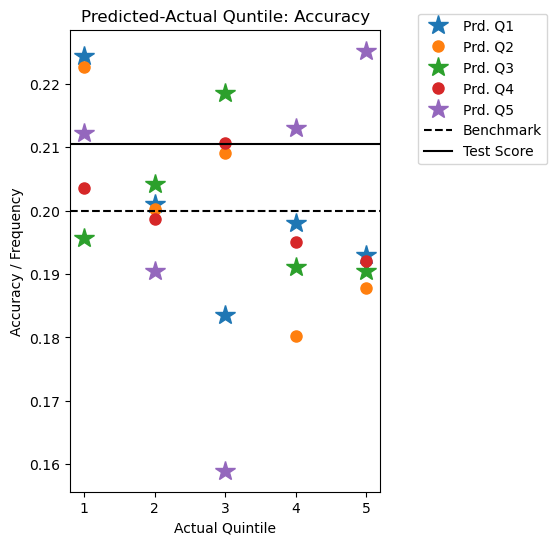

In [171]:
actual_frequency_name = os.path.join(model_folder, f"{model_type}_Actual_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots(figsize=(4,6))
ax3.plot(x_bar, true_dict[1], "*", markersize=15, label="Prd. Q1")
ax3.plot(x_bar, true_dict[2], "o", markersize=8, label="Prd. Q2")
ax3.plot(x_bar, true_dict[3], "*", markersize=15, label="Prd. Q3")
ax3.plot(x_bar, true_dict[4], "o", markersize=8, label="Prd. Q4")
ax3.plot(x_bar, true_dict[5], "*", markersize=15, label="Prd. Q5")
ax3.axhline(y=0.20, c="black", ls="--", label="Benchmark")
ax3.axhline(y=test_score, c="black", label="Test Score")
ax3.set_title("Predicted-Actual Quntile: Accuracy")
ax3.set_xticks([1, 2, 3, 4, 5])
ax3.set_xlabel("Actual Quintile")
ax3.set_ylabel("Accuracy / Frequency")
ax3.legend(bbox_to_anchor=(1.1, 1.05))
fig3.figure.savefig(actual_frequency_name, bbox_inches='tight', dpi=300)

In [ ]:
importance_name = os.path.join(model_folder, f"{model_type}_Importance.png")
df_importance = best_model.get_feature_importance(prettified=True)
df_importance = df_importance.sort_values(by='Importances').iloc[-10:]
fig7, ax7 = plt.subplots()
ax7.barh(df_importance['Feature Id'], df_importance['Importances'])
ax7.set_title("Feature Importance")
fig7.figure.savefig(importance_name, bbox_inches='tight', dpi=300)

### Exponential Decay

In [202]:
model_type = "exponential"
best_model = models_dict[model_type][0]

In [165]:
predictions = best_model.predict(X_test)
y_hat = predictions.reshape((len(predictions)))
y_true = (q_labeling(y, y_test)[1]).to_numpy()

In [166]:
test_score = accuracy_score(y_hat, y_true)
print(f"Test Accuracy: {test_score:.4f}")

Test Accuracy: 0.2105


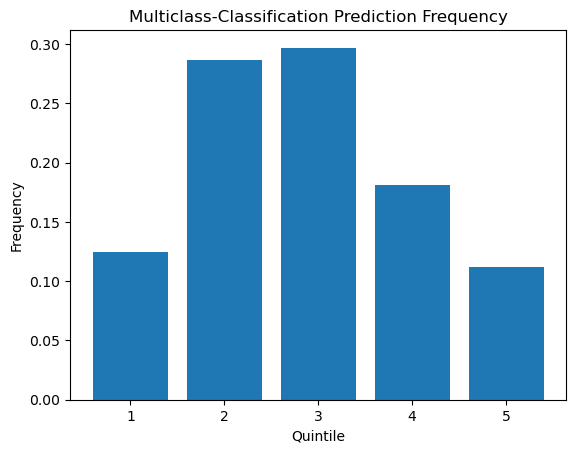

In [182]:
df_hat = pd.DataFrame({'predict':y_hat, 'true':y_true})
prediction_frequency_name = os.path.join(model_folder, f"{model_type}_Prediction_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots()
predict_count = df_hat['predict'].value_counts().sort_index()
predict_count = predict_count / predict_count.sum()
ax3.bar(x_bar, predict_count)
ax3.set_title("Multiclass-Classification Prediction Frequency")
ax3.set_xlabel("Quintile")
ax3.set_ylabel("Frequency")
fig3.figure.savefig(prediction_frequency_name, bbox_inches='tight', dpi=300)

In [169]:
true_dict = dict()
for i in range(1, 6):
    true_count = df_hat[df_hat['predict']==i]['true'].value_counts().sort_index()
    true_count = true_count / true_count.sum()
    true_dict[i] = true_count

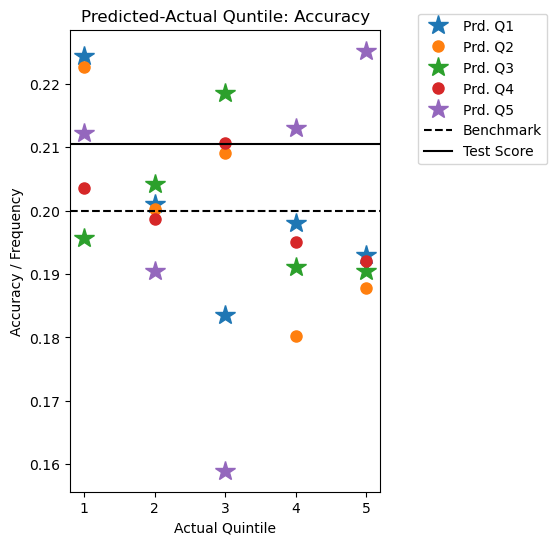

In [171]:
actual_frequency_name = os.path.join(model_folder, f"{model_type}_Actual_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots(figsize=(4,6))
ax3.plot(x_bar, true_dict[1], "*", markersize=15, label="Prd. Q1")
ax3.plot(x_bar, true_dict[2], "o", markersize=8, label="Prd. Q2")
ax3.plot(x_bar, true_dict[3], "*", markersize=15, label="Prd. Q3")
ax3.plot(x_bar, true_dict[4], "o", markersize=8, label="Prd. Q4")
ax3.plot(x_bar, true_dict[5], "*", markersize=15, label="Prd. Q5")
ax3.axhline(y=0.20, c="black", ls="--", label="Benchmark")
ax3.axhline(y=test_score, c="black", label="Test Score")
ax3.set_title("Predicted-Actual Quntile: Accuracy")
ax3.set_xticks([1, 2, 3, 4, 5])
ax3.set_xlabel("Actual Quintile")
ax3.set_ylabel("Accuracy / Frequency")
ax3.legend(bbox_to_anchor=(1.1, 1.05))
fig3.figure.savefig(actual_frequency_name, bbox_inches='tight', dpi=300)

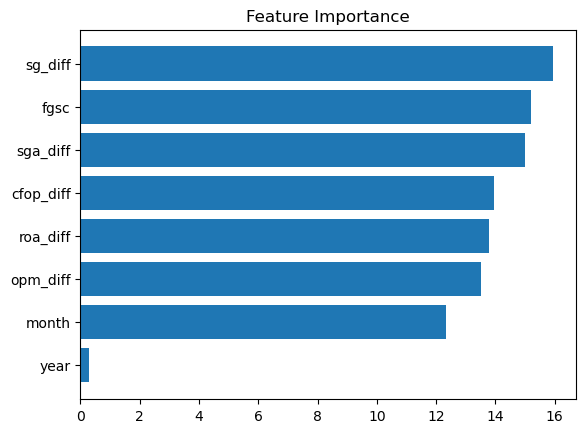

In [203]:
importance_name = os.path.join(model_folder, f"{model_type}_Importance.png")
df_importance = best_model.get_feature_importance(prettified=True)
df_importance = df_importance.sort_values(by='Importances').iloc[-10:]
fig7, ax7 = plt.subplots()
ax7.barh(df_importance['Feature Id'], df_importance['Importances'])
ax7.set_title("Feature Importance")
fig7.figure.savefig(importance_name, bbox_inches='tight', dpi=300)

## Save Model

In [17]:
model_folder = "model"
for key in models_dict.keys():
    model_name = os.path.join(model_folder, f"cat_{key}.json")
    models_dict[key][0].save_model(model_name, format="cbm",
                                     export_parameters=None, pool=None)